In [55]:
import sys
sys.path.insert(0, './src/')
from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K

from custom_layers import Scale



import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# from dataloader import image_dataset_from_directory
# from __future__ import print_function, division


import pathlib


# 1. Import data

In [2]:
current_directory = os.path.join(os.path.dirname(os.path.abspath("__file__")))
data_directory = os.path.join(current_directory, "data/removedBackGround_DataCurrency/")

data_dir = pathlib.Path(data_directory)


In [3]:
data_dir

PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency')

In [4]:
data_directory

'/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/'

In [5]:
os.listdir(data_dir)

['2000',
 '50000',
 '500000',
 '500000_pattern',
 '100000',
 '200000',
 '1000',
 '10000',
 '20000',
 '5000']

In [6]:
print(len(list(data_dir.glob('*/*.jpg')))+len(list(data_dir.glob('*/*.JPG'))))

926


## 1.1 Take a tour

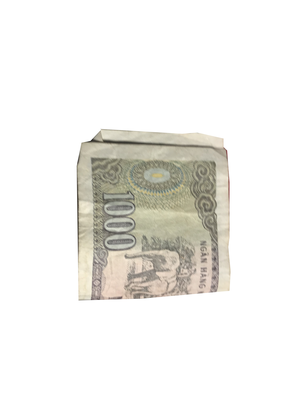

In [49]:
vn_1000 = list(data_dir.glob('1000/*'))
foo = Image.open(str(vn_1000[0]))
row,col = foo.size
foo.resize((row//10,col//10),Image.ANTIALIAS)

In [ ]:
vn_1000 = list(data_dir.glob('1000/*'))
foo = Image.open(str(vn_1000[0]))
row,col = foo.size
foo.resize((row//10,col//10),Image.ANTIALIAS)

In [68]:
vn_1000

[PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/IMG_2618.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2287944217521_6217de19adf49f6407c3d4cfacbf181d.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2286969783725_dd511a0d731c8d00b96775a53d336f7e.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2286969756600_a1022b778c3a6dce2dc092759d674b30.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2287782231736_189bdca66537851783ea52f831a7ac15.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2287949406435_a7435458c4b5d0e9797edc5a9bfe9e65.jpg'),
 PosixPath('/home/hoangtrieuvy-le/Documents/H3project/data/removedBackGround_DataCurrency/1000/z2287782288375_9fa7da94fda2fa40cc7c752d24b01

# 2. Extract feature

## 2.1 Extracting Edge Features

In [56]:
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v

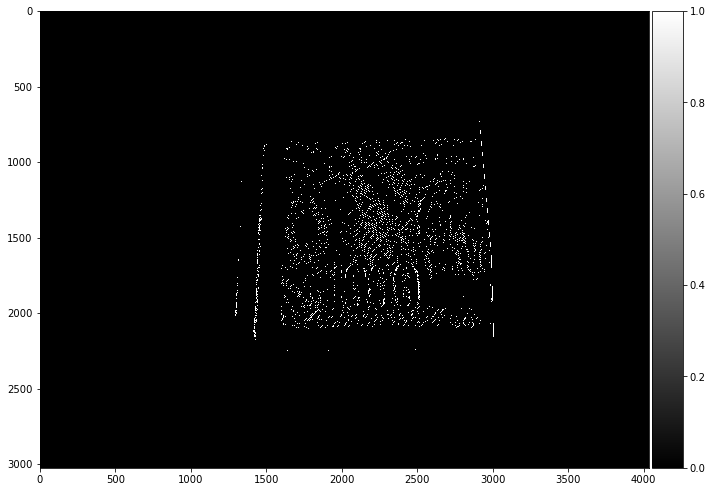

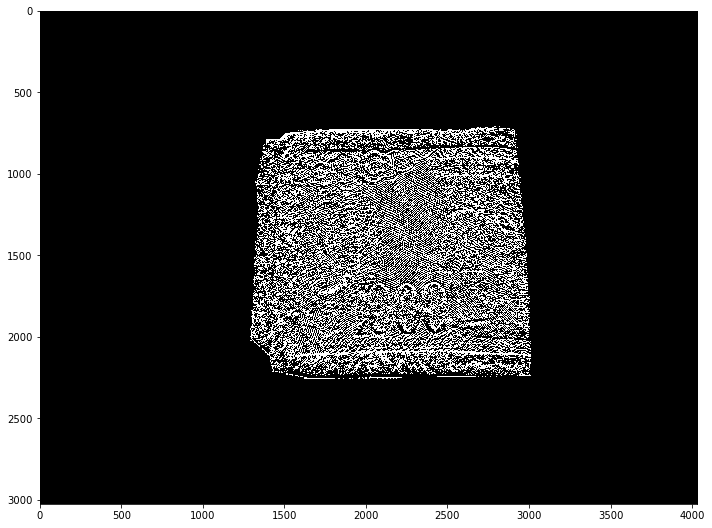

In [71]:
img_temp =  imread(str(vn_1000[0]),as_gray=True)

#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img_temp)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(img_temp)
plt.figure(figsize=(10,10))
imshow(edges_prewitt_vertical>0.05, cmap='gray')
plt.figure(figsize=(10,10))
imshow(edges_prewitt_horizontal>0, cmap='gray')

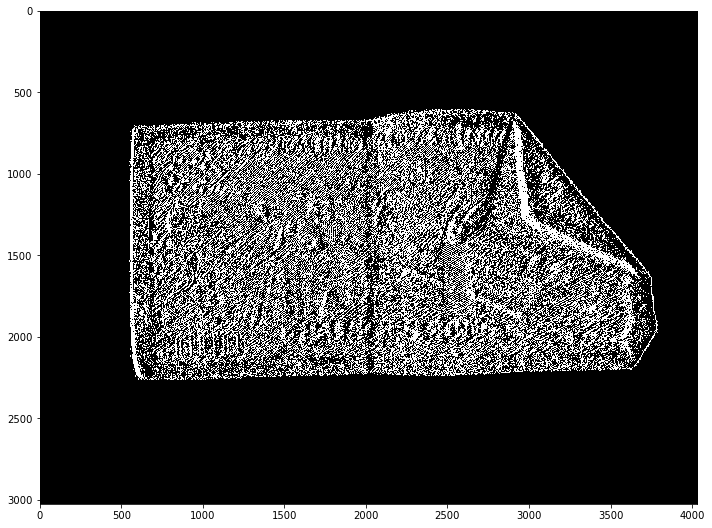

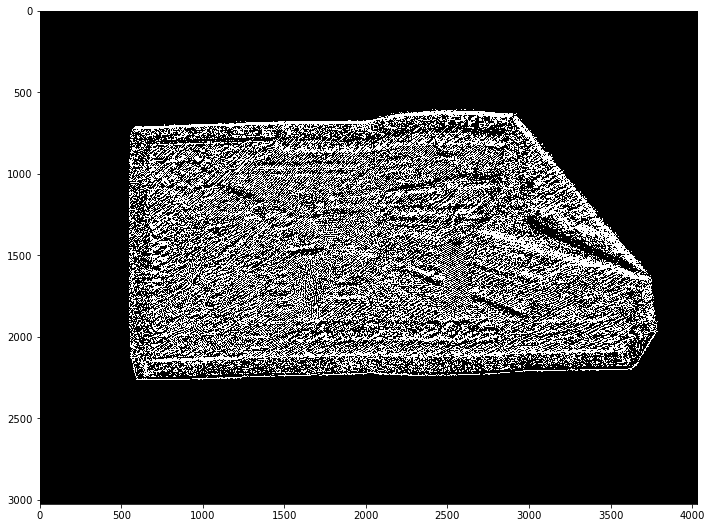

In [74]:
vn_2000 = list(data_dir.glob('2000/*'))
img_temp =  imread(str(vn_2000[0]),as_gray=True)

#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img_temp)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(img_temp)
plt.figure(figsize=(10,10))
imshow(edges_prewitt_vertical>0, cmap='gray')
plt.figure(figsize=(10,10))
imshow(edges_prewitt_horizontal>0, cmap='gray')

# 3 Explore each layer of Densenet169

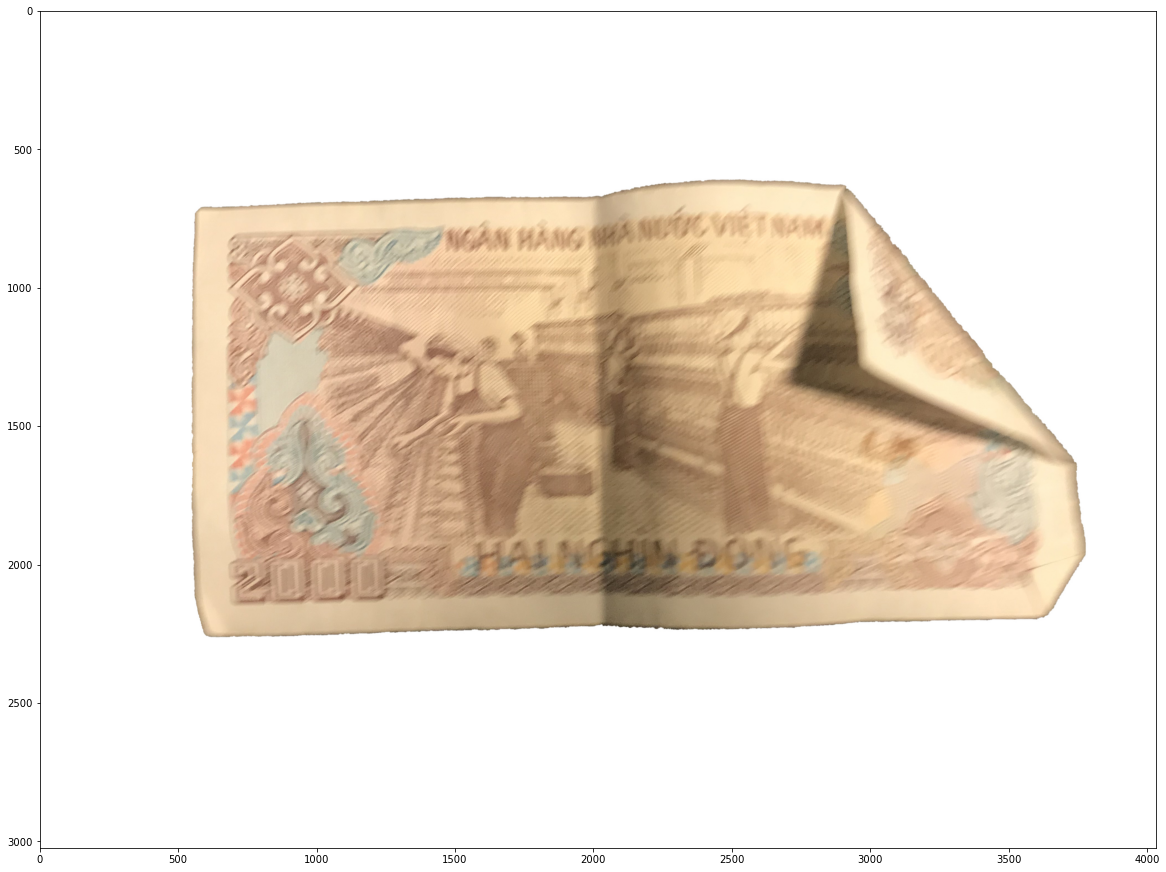

In [159]:
# Layer 1

img_temp =  imread(str(vn_1000[0]))

plt.figure(figsize=(20,20))
plt.imshow(img_temp)
plt.show()

# out_layer_1 = 

# 4. DenseNet169

In [88]:

def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None):
    '''Instantiate the DenseNet architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
        concat_axis = 3
        img_input = Input(shape=(224, 224, 3), name='data')
    else:
        concat_axis = 1
        img_input = Input(shape=(3, 224, 224), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,32,32] # For DenseNet-169

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(img_input, x, name='densenet')

    if weights_path is not None:
        model.load_weights(weights_path)

    return model


def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [103]:
img_temp= img_temp.reshape(3024,4032,3,1)

In [140]:
img_input= tf.image.convert_image_dtype(img_temp, dtype=tf.float32, saturate=False)


In [158]:
x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_zeropadding')(img_input)
# x = Convolution2D(1024, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
x = Convolution2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
x = BatchNormalization(epsilon=1.001e-5, axis=3, name='conv1_bn')(x)
x = Scale(axis=3, name='conv1_scale')(x)
# x = Activation('relu', name='relu1')(x)
# x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
# x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)


NameError: name 'concat_axis' is not defined

In [155]:
x.shape

TensorShape([3024, 2016, 2, 64])

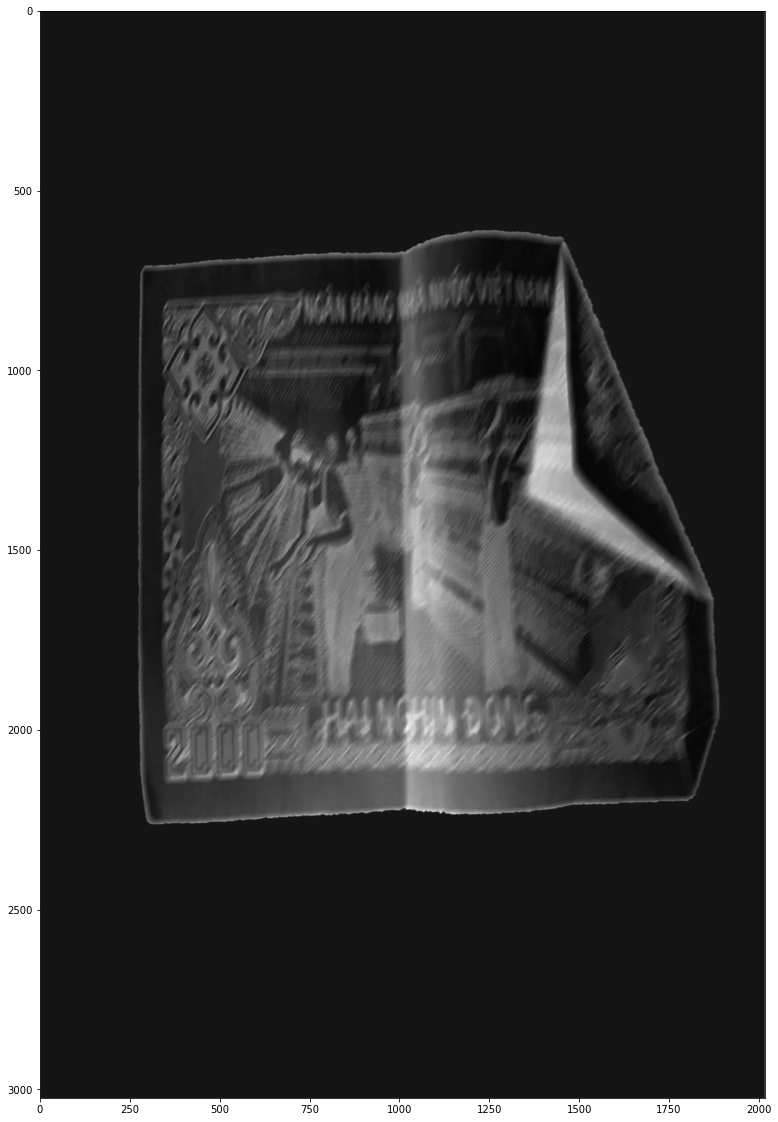

In [156]:
plt.figure(figsize=(20,20))
plt.imshow(x[:,:,1,5],'gray')
plt.show()

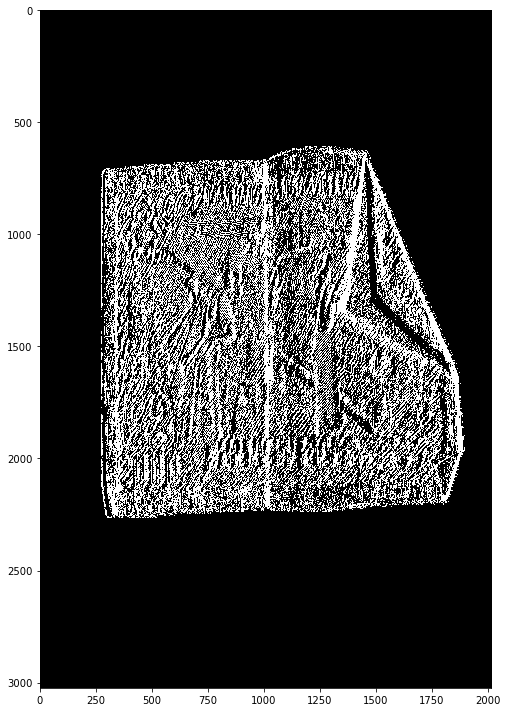

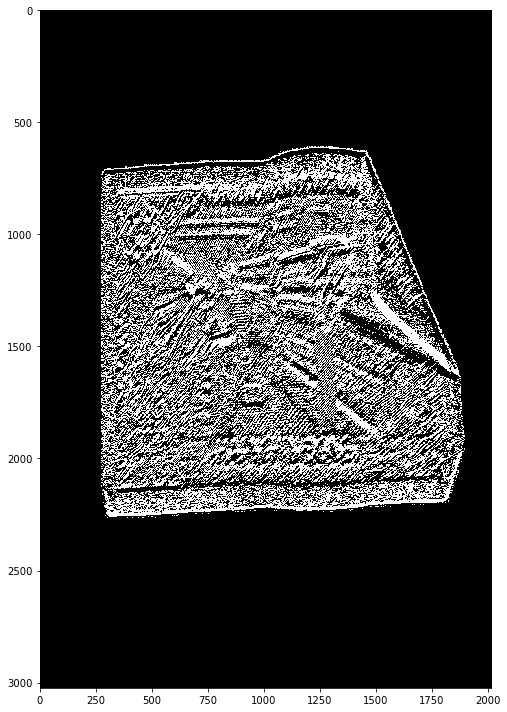

In [157]:
#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(x[:,:,1,5])
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(x[:,:,1,5])
plt.figure(figsize=(10,10))
imshow(edges_prewitt_vertical>0, cmap='gray')
plt.figure(figsize=(10,10))
imshow(edges_prewitt_horizontal>0, cmap='gray')

0. Chụp ảnh 2 mặt:
    - mặt 1: img1
    - mặt 2: img2
    - labeling 
    
    - background: màu trắng 
    - Tìm vị trí tờ tiền ( bounding box)
    
1. Pre-processing data:

    - (Feature của tờ tiền):
        1. bác hồ
        2. quốc huy

    - Feature của các tờ tiền khác nhau:
        1. giá trị của tờ tiềuy
        2. Biểu tượng (nhà, chùa một cột,/...)
        


2. Training


3. Classification

In [160]:
from skimage.metrics import structural_similarity as ssim


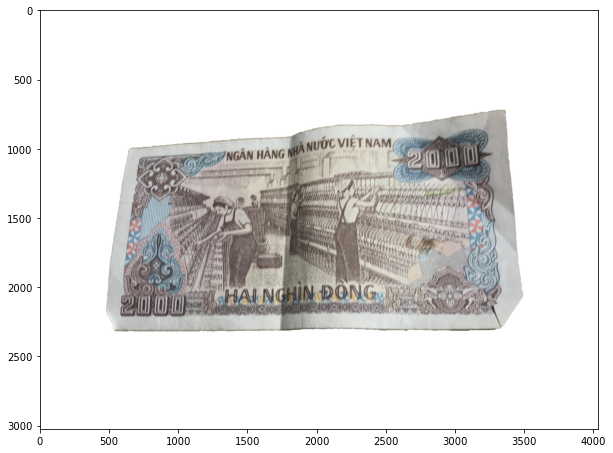

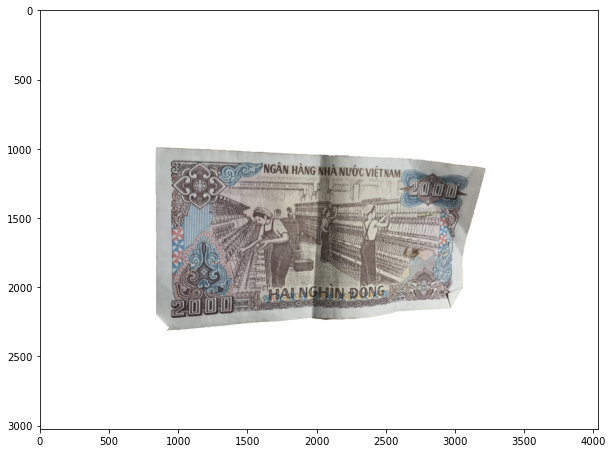

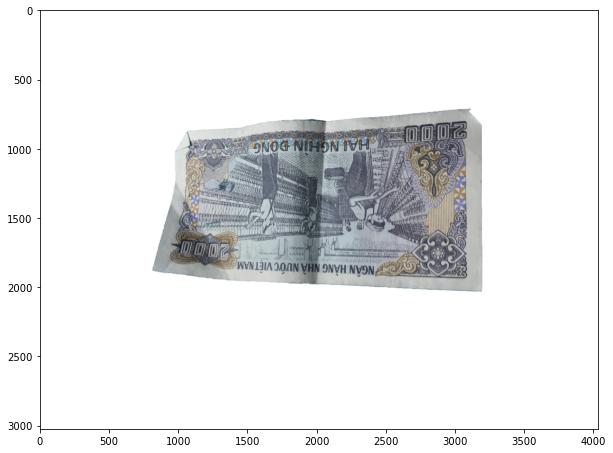

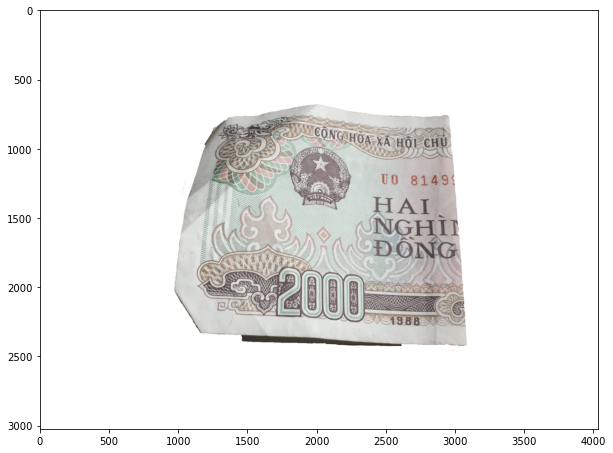

In [181]:
img_temp1 =  imread(str(vn_1000[10]))

plt.figure(figsize=(10,10))
plt.imshow(img_temp1)
plt.show()

img_temp2 =  imread(str(vn_1000[4]))

plt.figure(figsize=(10,10))
plt.imshow(img_temp2)
plt.show()

img_temp3 =  np.flip(img_temp2)

plt.figure(figsize=(10,10))
plt.imshow(img_temp3)
plt.show()

img_temp4 =  imread(str(vn_1000[5]))

plt.figure(figsize=(10,10))
plt.imshow(img_temp4)
plt.show()


In [176]:
ssim(img_temp1[:,:,0],img_temp2[:,:,0])

0.7676374338402843

In [183]:
ssim(img_temp1[:,:,0],img_temp4[:,:,0])

0.7515396385966236

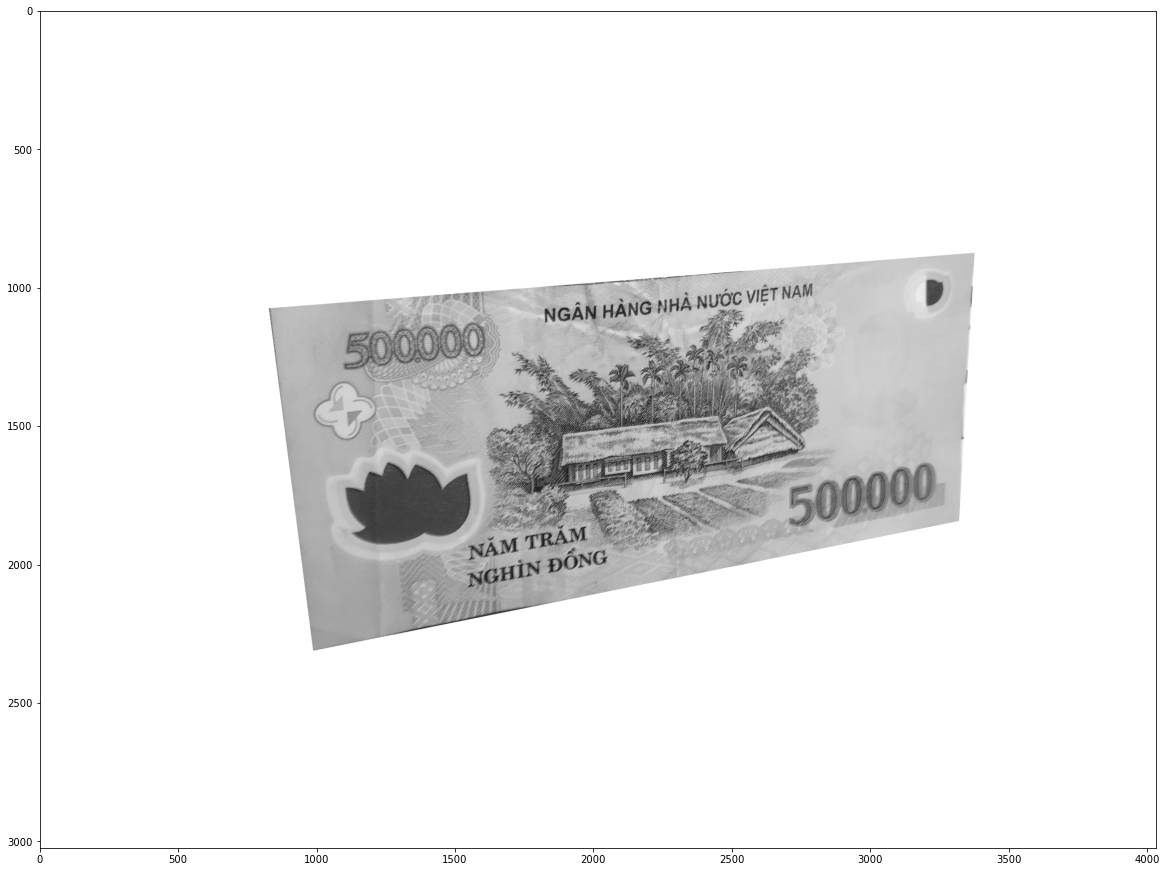

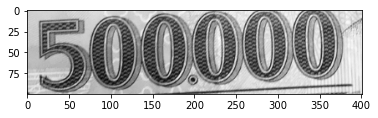

In [198]:
import cv2

template = cv2.imread('./data/removedBackGround_DataCurrency/500000_pattern/digit.jpg')
grey_template = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


vn_500k = list(data_dir.glob('500000/*'))
temp_500k =  cv2.imread(str(vn_500k[5]))
grey_temp_500k = cv2.cvtColor(temp_500k,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,20))
plt.imshow(grey_temp_500k,'gray')
plt.show()
plt.figure()
plt.imshow(grey_template,'gray')
plt.show()

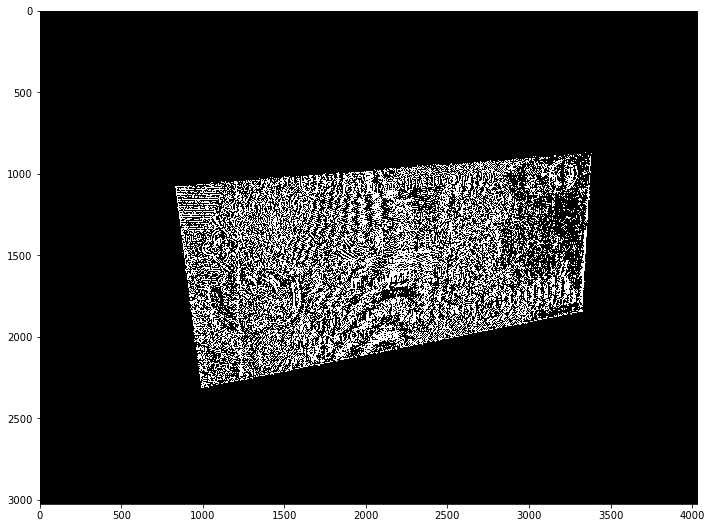

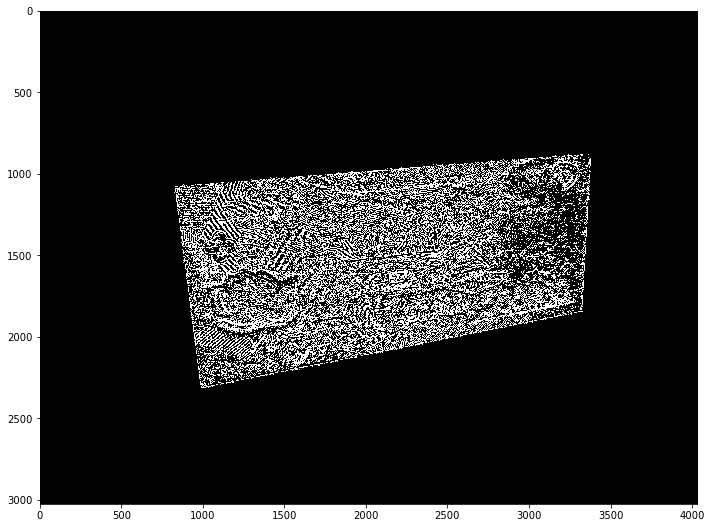

In [58]:
#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(grey_temp_500k)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(grey_temp_500k)
plt.figure(figsize=(10,10))
imshow(edges_prewitt_vertical>0, cmap='gray')
plt.figure(figsize=(10,10))
imshow(edges_prewitt_horizontal>0, cmap='gray')

In [119]:

w,h = template.shape[::-1]
res = cv2.matchTemplate(grey_temp_500k,grey_template,cv2.TM_CCOEFF_NORMED)
threshold= 0.319
loc = np.where(res>threshold)
plt.figure(figsize=(20,20))
for pt in zip(*loc[::-1]):
    cv2.rectangle(temp_500k,pt,(pt[0]+w,pt[1]+h),(0,0,255),2)
    
plt.imshow(temp_500k)
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
def shi_tomashi(image):
    """
    Use Shi-Tomashi algorithm to detect corners
    Args:
        image: np.array
    Returns:
        corners: list
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.1, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print('\nThe corner points are...\n')

    im = image.copy()
    for index, c in enumerate(corners):
        x, y = c
        cv2.circle(im, (x, y), 50, 255, -1)
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(im, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0 , 255), 2, cv2.LINE_AA)
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.title('Corner Detection: Shi-Tomashi')
    plt.show()
    return corners

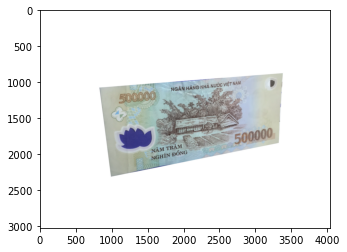

In [120]:
plt.imshow(temp_500k)

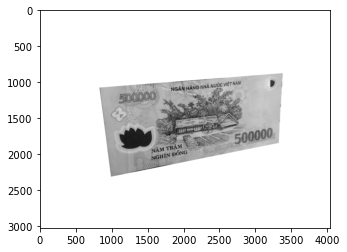

In [130]:
def apply_filter(image):
    """
    Define a 5X5 kernel and apply the filter to gray scale image
    Args:
        image: np.array
    Returns:
        filtered: np.array
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5, 5), np.float32) / 30
    filtered = cv2.filter2D(gray, -1, kernel)
#     plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
#     plt.title('Filtered Image')
#     plt.show()
    return filtered

filtered = apply_filter(temp_500k)
plt.imshow(filtered,'gray')


In [132]:
def apply_threshold(filtered):
    """
    Apply OTSU threshold
    Args:
        filtered: np.array
    Returns:
        thresh: np.array
    """
#     ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_TOZERO)
    ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_BINARY)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
#     plt.title('After applying OTSU threshold')
    plt.show()
    return thresh




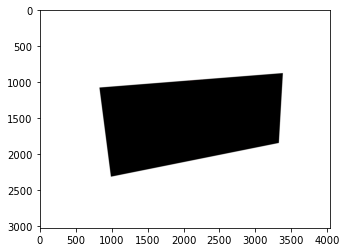


The corner points are...

A : [827, 1076]
B : [987, 2310]
C : [3319, 1843]
D : [3376, 876]


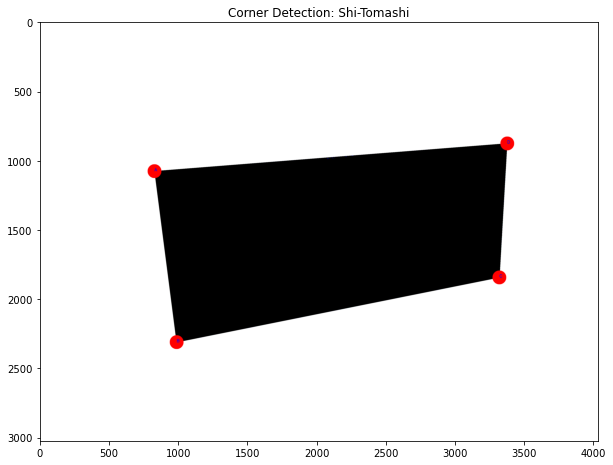

In [134]:
corners = shi_tomashi(apply_threshold(temp_500k))


In [178]:
def get_destination_points(corners):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
    Args:
        corners: list
    Returns:
        destination_corners: list
        height: int
        width: int
    """

    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([ (w - 1, h - 1),(0, h - 1),(0, 0), (w - 1, 0) ])

    print('\nThe destination points are: \n')
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)

    print('\nThe approximated height and width of the original image is: \n', (h, w))
    return destination_corners, h, w


def unwarp(img, src, dst):
    """
    Args:
        img: np.array
        src: list
        dst: list
    Returns:
        un_warped: np.array
    """
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    print('\nThe homography matrix is: \n', H)
    un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)

    # plot

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    # f.subplots_adjust(hspace=.2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

    ax2.imshow(img)
    ax2.plot(x, y, color='yellow', linewidth=3)
    ax2.set_ylim([h, 0])
    ax2.set_xlim([0, w])
    ax2.set_title('Target Area')

    plt.show()
    return un_warped

In [179]:
dst,h,w = get_destination_points(corners)


The destination points are: 

A' : [1243. 2785.]
B' : [   0. 2785.]
C' : [0. 0.]
D' : [1243.    0.]

The approximated height and width of the original image is: 
 (2786, 1244)


In [182]:
np.float32(corners)
dst = np.array([[0,0],[650,0],[650,1520],[0,1520]])


The homography matrix is: 
 [[ 3.23293186e-02  4.12037165e-01 -4.70088336e+02]
 [ 3.87631111e-01 -5.02601116e-02 -2.66491049e+02]
 [-8.78756458e-05 -5.32779399e-05  1.00000000e+00]]


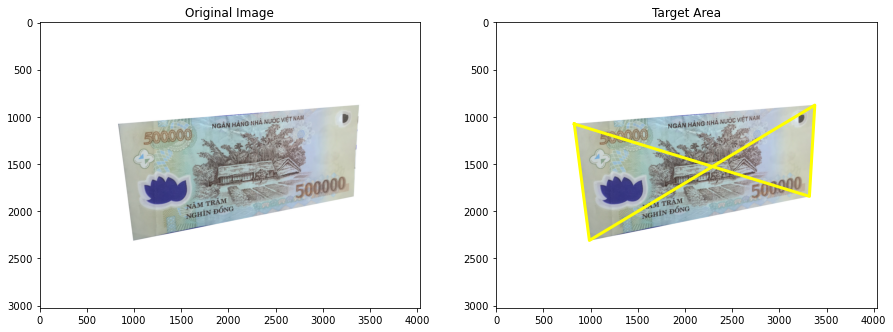

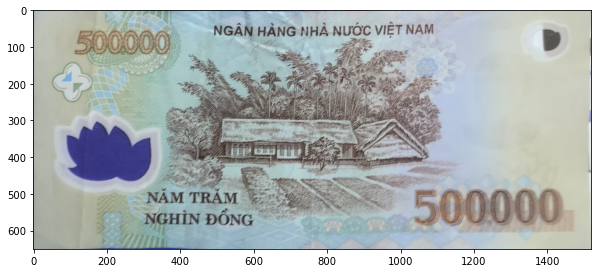

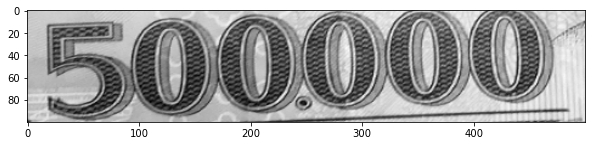

In [222]:
un_warped= unwarp(temp_500k,np.float32(corners),dst)[:1520,:650]
un_warped=np.rot90(np.flip(un_warped,0),3)
plt.figure(figsize=(10,10))
plt.imshow(un_warped)
plt.show()
grey_unwarped = cv2.cvtColor(un_warped,cv2.COLOR_BGR2GRAY)

grey_temp_500k_resized = cv2.resize(grey_template, dsize=(500, 100), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(10,10))
plt.imshow(grey_temp_500k_resized,'gray')
plt.show()

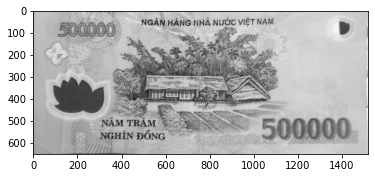

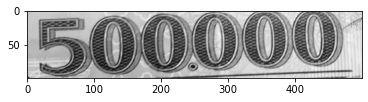

In [224]:
plt.figure()
plt.imshow(grey_unwarped,'gray')
plt.show()
plt.figure()
plt.imshow(grey_temp_500k_resized,'gray')
plt.show()

(array([480]), array([1012]))


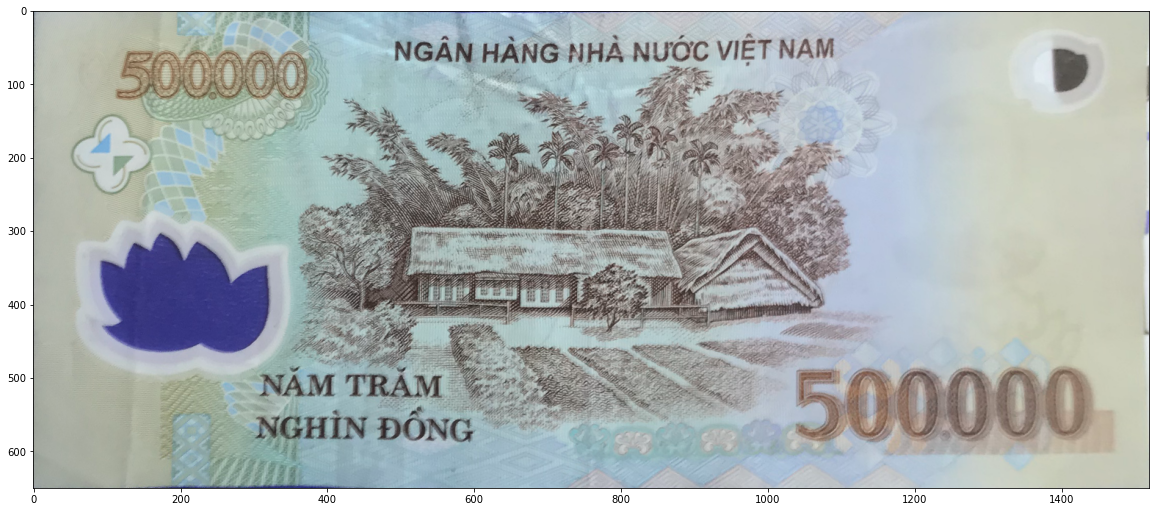

In [246]:

w,h = grey_temp_500k_resized.shape[::-1]
res = cv2.matchTemplate(grey_unwarped,grey_temp_500k_resized,cv2.TM_CCOEFF_NORMED)
threshold= 0.361
loc = np.where(res>threshold)
plt.figure(figsize=(20,20))
plt.imshow(un_warped)
print(loc)